In [491]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from tsfeatures import tsfeatures
from tsfeatures import acf_features

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.metrics import mean_squared_error




from ts_tools.tools import tools
from data_loading_finance.loading_data import LoadingData


In [432]:
df = pd.read_csv("/Users/marcosherediapimienta/Library/Mobile Documents/com~apple~CloudDocs/Documents/Máster de Matemàtiques per els Instruments Financers/TFM/Time_Series/archive/Top10-2021-2024-1d.csv")
df.head()

,Timestamp,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,USDCUSDT,XRPUSDT,DOGEUSDT,ADAUSDT,SHIBUSDT,AVAXUSDT
0,1/1/2021,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69
1,1/2/2021,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33
2,1/3/2021,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05
3,1/4/2021,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71
4,1/5/2021,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53


In [433]:
# Seleccionar las columnas deseadas del DataFrame original
df_selected = df[['Timestamp', 'BTCUSDT']]
df_selected = df_selected.rename(columns={'Timestamp':'date', 'BTCUSDT': 'BTC'})
df_selected = df_selected.dropna()
print(df_selected)

           date       BTC
0      1/1/2021  29331.69
1      1/2/2021  32178.33
2      1/3/2021  33000.05
3      1/4/2021  31988.71
4      1/5/2021  33949.53
...         ...       ...
1240  5/25/2024  69290.57
1241  5/26/2024  68507.67
1242  5/27/2024  69436.43
1243  5/28/2024  68398.39
1244  5/29/2024  67652.42

[1245 rows x 2 columns]


In [434]:
df_selected["unique_id"]="1"
df_selected.columns=["ds", "y", "unique_id"]
df_selected.head()

,ds,y,unique_id
0,1/1/2021,29331.69,1
1,1/2/2021,32178.33,1
2,1/3/2021,33000.05,1
3,1/4/2021,31988.71,1
4,1/5/2021,33949.53,1


In [435]:
print(df_selected.dtypes)

ds            object
y            float64
unique_id     object
dtype: object


**Apuntes**

En este apartado, hemos verificado rápidamente qué tipo de datos tiene cada columna, lo cual es crucial para asegurar que los datos se estén procesando correctamente y para elegir las operaciones adecuadas a realizar sobre ellos.

object: indica que es una columna de tipo objeto (generalmente significa que contiene cadenas de texto u otros tipos de datos no numéricos).
float64: indica que es una columna de números de punto flotante (números decimales).

In [436]:
df_selected["ds"] = pd.to_datetime(df_selected["ds"])
print(df_selected.dtypes)

ds           datetime64[ns]
y                   float64
unique_id            object
dtype: object


**Apuntes**

En este apartado lo que he hecho es convertir la columna (tipo object) a serie temporal (datetime64[ns]).

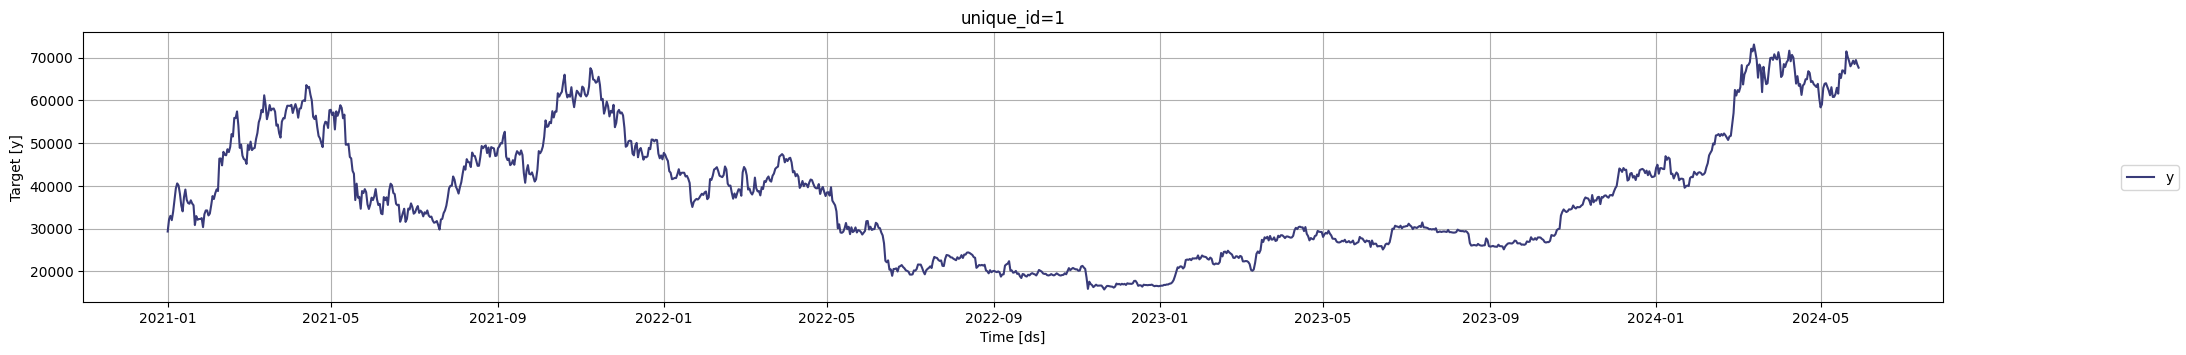

In [437]:
StatsForecast.plot(df_selected, engine="matplotlib")

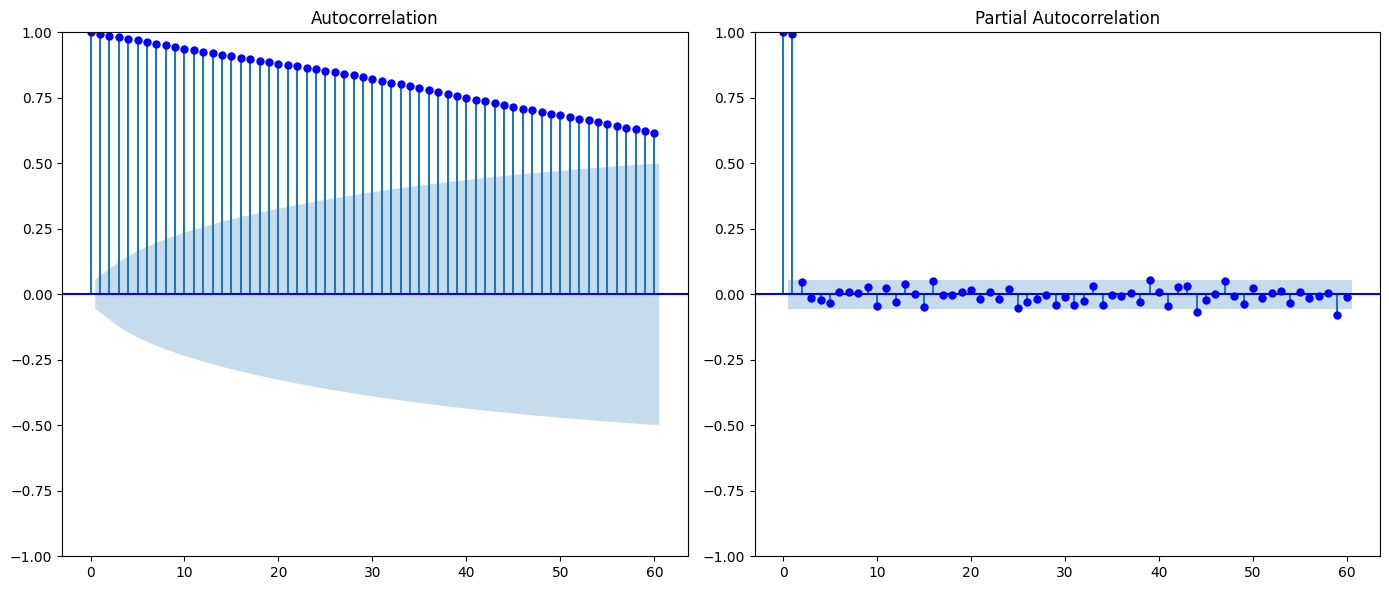

In [438]:
# Crear una figura con dos subgráficos
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Graficar ACF en el primer subgráfico
plot_acf(df_selected["y"], lags=60, ax=axs[0], color="blue")
axs[0].set_title("Autocorrelation")

# Graficar PACF en el segundo subgráfico
plot_pacf(df_selected["y"], lags=60, ax=axs[1], color="blue")
axs[1].set_title('Partial Autocorrelation')

# Ajustar el diseño para que no haya superposición de elementos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

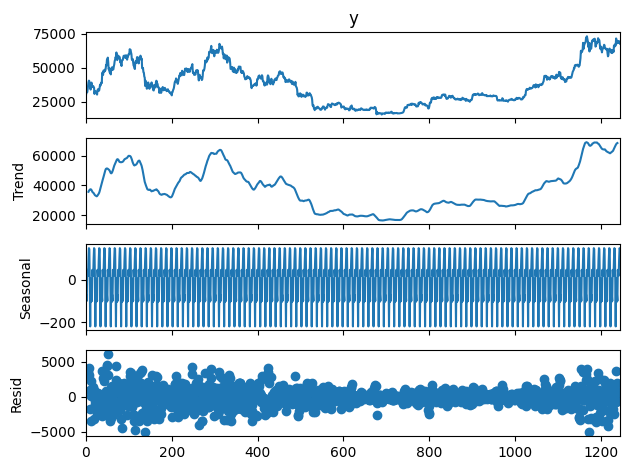

In [439]:
# Descomponer la serie temporal
decomposition = seasonal_decompose(df_selected['y'], model='additive', period=12)
decomposition.plot()
plt.show()

In [440]:
Y_train_df = df_selected[df_selected.ds<='2024-05-01'] 
Y_test_df = df_selected[df_selected.ds>'2024-05-01']
Y_train_df.shape, Y_test_df.shape

((1217, 3), (28, 3))

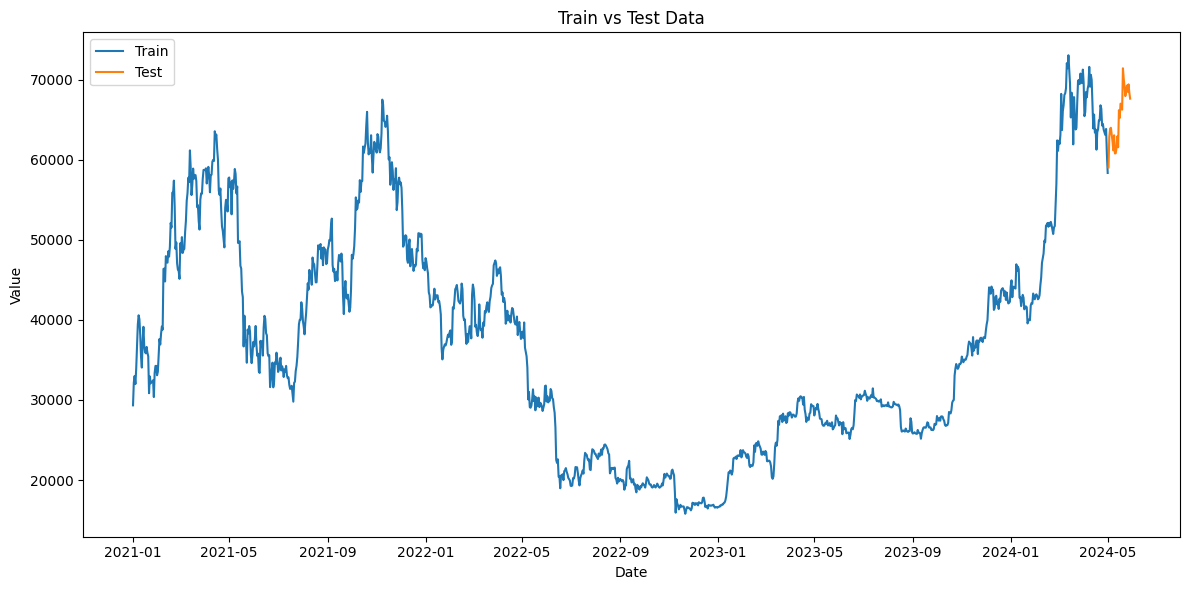

In [441]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Graficar las series temporales de entrenamiento y prueba
sns.lineplot(data=Y_train_df, x="ds", y="y", label="Train")
sns.lineplot(data=Y_test_df, x="ds", y="y", label="Test")

# Personalizar etiquetas y título
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Train vs Test Data")
plt.legend()
plt.tight_layout()  
plt.show()


In [476]:
season_length = 12 # Monthly data 
horizon = len(Y_test_df) # number of predictions

models = [AutoARIMA(season_length=season_length)]

In [477]:
sf = StatsForecast(df=Y_train_df,
                   models=models,
                   freq='D', 
                   n_jobs=-1)

In [478]:
sf.fit()

StatsForecast(models=[AutoARIMA])

In [479]:
arima_string(sf.fitted_[0,0].model_)

'ARIMA(1,1,0)(2,0,0)[12]                   '

In [480]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])


dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(1, 0, 2, 0, 12, 1, 0)


In [481]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,29.331675
1,2829.970931
2,1004.583062
3,-953.916880
4,1887.488150
...,...
1212,-491.087535
1213,-506.649612
1214,613.118183
1215,-3092.090947


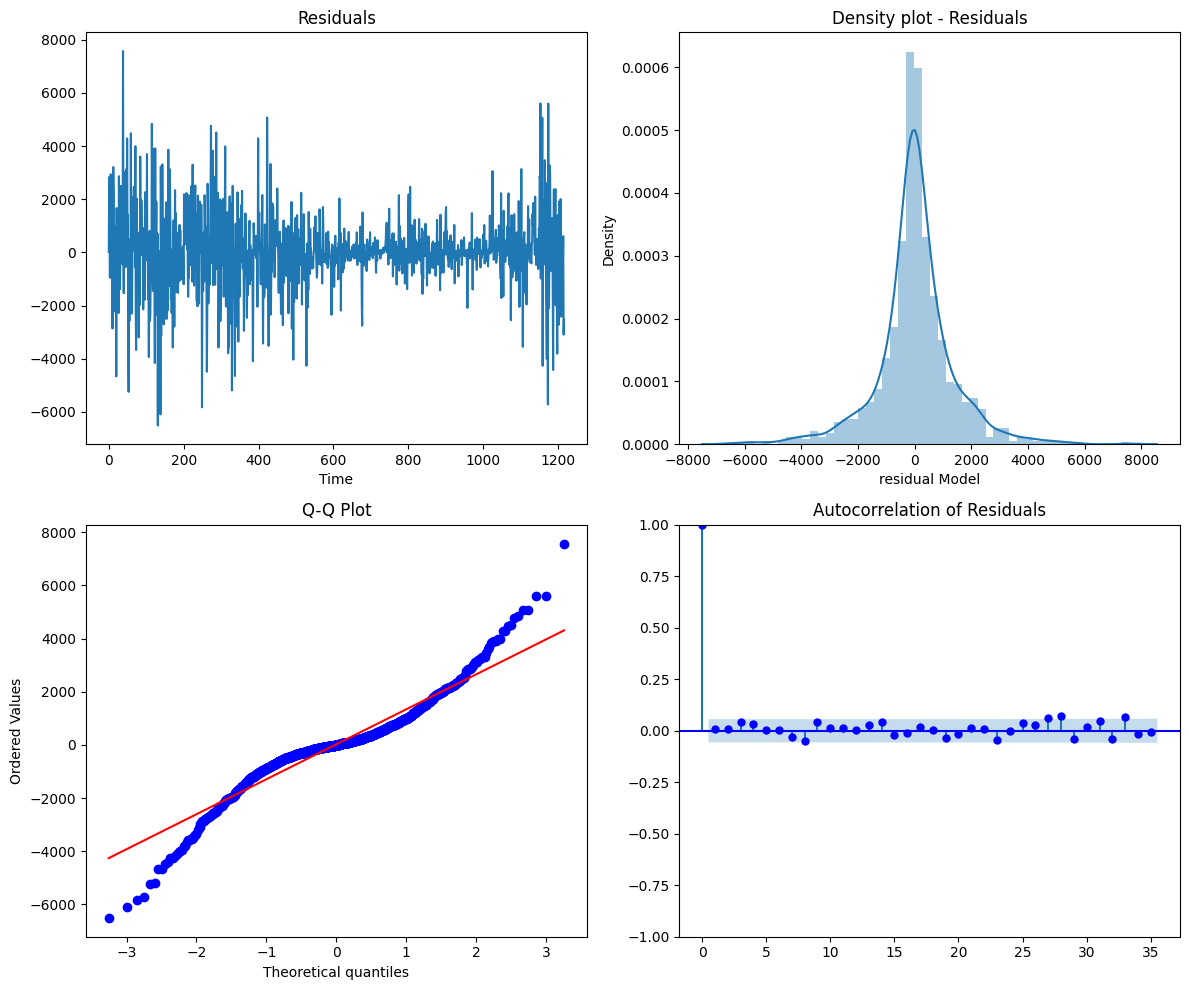

In [482]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot de Residuos
residual['residual Model'].plot(ax=axs[0, 0])
axs[0, 0].set_title("Residuals")
axs[0, 0].set_xlabel('Time')

# Density plot - Residuos
sns.distplot(residual['residual Model'], ax=axs[0, 1])
axs[0, 1].set_title("Density plot - Residuals")

# Q-Q Plot de Residuos
stats.probplot(residual['residual Model'], dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot')

# Autocorrelation de Residuos
plot_acf(residual['residual Model'], lags=35, ax=axs[1, 1], color="blue")
axs[1, 1].set_title("Autocorrelation of Residuals")

plt.tight_layout()
plt.show()


In [483]:
Y_hat_df = sf.forecast(horizon, fitted=True)
Y_hat_df.head()

,ds,AutoARIMA
unique_id,,
1,2024-05-02,58590.480469
1,2024-05-03,58429.542969
1,2024-05-04,58413.492188
1,2024-05-05,58398.480469
1,2024-05-06,58343.550781


In [484]:
Y_hat_df.tail()

,ds,AutoARIMA
unique_id,,
1,2024-05-25,58141.460938
1,2024-05-26,58152.042969
1,2024-05-27,58141.695312
1,2024-05-28,58134.117188
1,2024-05-29,58134.562500


In [485]:
values=sf.forecast_fitted_values()
values


,ds,y,AutoARIMA
unique_id,,,
1,2021-01-01,29331.689453,29302.357422
1,2021-01-02,32178.330078,29348.359375
1,2021-01-03,33000.050781,31995.466797
1,2021-01-04,31988.710938,32942.625000
1,2021-01-05,33949.531250,32062.041016
...,...,...,...
1,2024-04-27,63461.980469,63953.066406
1,2024-04-28,63118.621094,63625.269531
1,2024-04-29,63866.000000,63252.882812


In [486]:
sf.forecast(h=28, level=[95])


,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
unique_id,,,,
1,2024-05-02,58590.480469,55904.527344,61276.433594
1,2024-05-03,58429.542969,54753.417969,62105.664062
1,2024-05-04,58413.492188,53955.746094,62871.238281
1,2024-05-05,58398.480469,53277.417969,63519.546875
1,2024-05-06,58343.550781,52635.718750,64051.382812
1,2024-05-07,58136.851562,51897.191406,64376.511719
1,2024-05-08,58284.476562,51554.886719,65014.066406
1,2024-05-09,58165.285156,50979.085938,65351.480469
1,2024-05-10,58207.687500,50592.210938,65823.164062


In [453]:
Y_hat_df=Y_hat_df.reset_index()
Y_hat_df

,unique_id,ds,AutoARIMA
0,1,2024-05-02,58590.480469
1,1,2024-05-03,58429.542969
2,1,2024-05-04,58413.492188
3,1,2024-05-05,58398.480469
4,1,2024-05-06,58343.550781
5,1,2024-05-07,58136.851562
6,1,2024-05-08,58284.476562
7,1,2024-05-09,58165.285156
8,1,2024-05-10,58207.687500
9,1,2024-05-11,58011.460938


In [455]:
sf.predict(h=28)

,ds,AutoARIMA
unique_id,,
1,2024-05-02,58590.480469
1,2024-05-03,58429.542969
1,2024-05-04,58413.492188
1,2024-05-05,58398.480469
1,2024-05-06,58343.550781
1,2024-05-07,58136.851562
1,2024-05-08,58284.476562
1,2024-05-09,58165.285156
1,2024-05-10,58207.687500


In [456]:
forecast_df = sf.predict(h=28, level = [80, 95]) 

forecast_df

,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
unique_id,,,,,,
1,2024-05-02,58590.480469,55904.527344,56834.230469,60346.730469,61276.433594
1,2024-05-03,58429.542969,54753.417969,56025.855469,60833.230469,62105.664062
1,2024-05-04,58413.492188,53955.746094,55498.730469,61328.253906,62871.238281
1,2024-05-05,58398.480469,53277.417969,55050.000000,61746.964844,63519.546875
1,2024-05-06,58343.550781,52635.718750,54611.398438,62075.699219,64051.382812
1,2024-05-07,58136.851562,51897.191406,54056.957031,62216.746094,64376.511719
1,2024-05-08,58284.476562,51554.886719,53884.234375,62684.718750,65014.066406
1,2024-05-09,58165.285156,50979.085938,53466.480469,62864.085938,65351.480469
1,2024-05-10,58207.687500,50592.210938,53228.195312,63187.179688,65823.164062


In [458]:
df_plot=pd.concat([df_selected, forecast_df]).set_index('ds').tail(220)
df_plot

,y,unique_id,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-80,AutoARIMA-hi-95
ds,,,,,,,
2023-11-20,37448.78,1,NaN,NaN,NaN,NaN,NaN
2023-11-21,35741.65,1,NaN,NaN,NaN,NaN,NaN
2023-11-22,37408.34,1,NaN,NaN,NaN,NaN,NaN
2023-11-23,37294.28,1,NaN,NaN,NaN,NaN,NaN
2023-11-24,37713.57,1,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2024-05-25,NaN,NaN,58141.460938,46108.207031,50273.339844,66009.585938,70174.710938
2024-05-26,NaN,NaN,58152.042969,45851.703125,50109.285156,66194.804688,70452.382812
2024-05-27,NaN,NaN,58141.695312,45582.238281,49929.507812,66353.882812,70701.156250


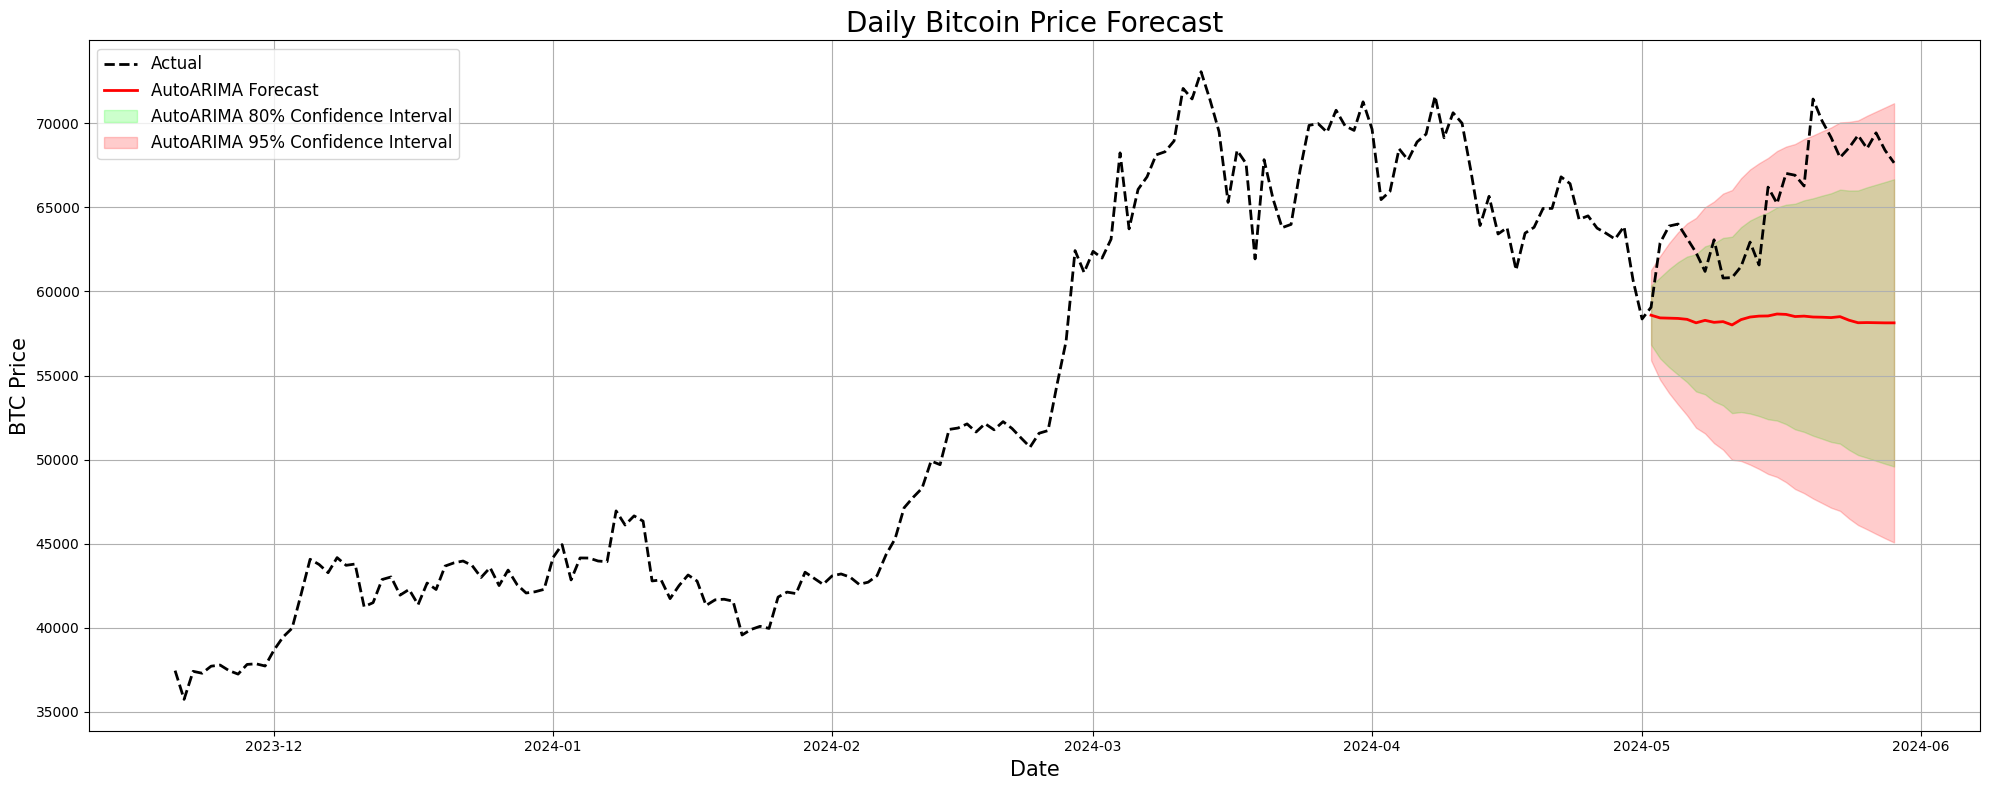

In [487]:
# Asumiendo que df_plot contiene las columnas necesarias y está preparado para trazar

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

# Graficar las series y la predicción
plt.plot(df_plot.index, df_plot['y'], 'k--', label="Actual", linewidth=2)
plt.plot(df_plot.index, df_plot['AutoARIMA'], 'b-', label="AutoARIMA Forecast", linewidth=2, color="red")

# Rellenar las bandas de intervalo de confianza del 80% y 95%
ax.fill_between(df_plot.index, 
                df_plot['AutoARIMA-lo-80'], 
                df_plot['AutoARIMA-hi-80'],
                alpha=.20,
                color='lime',
                label='AutoARIMA 80% Confidence Interval')
ax.fill_between(df_plot.index, 
                df_plot['AutoARIMA-lo-95'], 
                df_plot['AutoARIMA-hi-95'],
                alpha=.2,
                color='red',
                label='AutoARIMA 95% Confidence Interval')

# Configurar título y etiquetas de los ejes
ax.set_title('Daily Bitcoin Price Forecast', fontsize=20)
ax.set_ylabel('BTC Price', fontsize=15)
ax.set_xlabel('Date', fontsize=15)

# Añadir leyenda
ax.legend(prop={'size': 12})

# Mostrar la cuadrícula
ax.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

